### Autoencoders for MNIST classification

In [1]:
%matplotlib inline
import os
import struct
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets as dsets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy

In [2]:
import codecs

In [3]:
# Download datasets
download= dsets.MNIST('./MNIST/', train= True, download= True)

In [4]:
DATAPATH= './MNIST/raw/'

In [5]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [6]:
def parse_byte(b):
    if(isinstance(b, str)):
        return ord(b)
    return b

In [7]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data= f.read();
        assert get_int(data[:4])==2051
        length= get_int(data[4:8])
        num_rows= get_int(data[8:12])
        num_cols= get_int(data[12:16])
        images=[]
        idx=16
        for l in range(length):
            img=[]
            images.append(img)
            for r in range(num_rows):
                row=[]
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx+=1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1, 784)                

In [8]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data= f.read()
        assert get_int(data[:4]) ==2049
        length= get_int(data[4:8])
        labels= [parse_byte(b) for b in data[8:]]
        assert len(labels)== length
        return torch.LongTensor(labels)

In [9]:
TrainImages= read_image_file(os.path.join(DATAPATH, 'train-images-idx3-ubyte'))
TrainLabels= read_label_file(os.path.join(DATAPATH, 'train-labels-idx1-ubyte'))
TestImages= read_image_file(os.path.join(DATAPATH, 't10k-images-idx3-ubyte'))
TestLabels= read_label_file(os.path.join(DATAPATH, 't10k-labels-idx1-ubyte'))

In [10]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


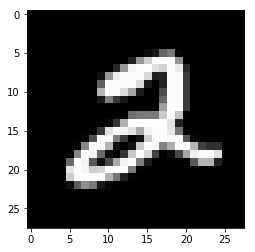

In [11]:
img= TrainImages[1:].view((59999,28, 28)).numpy()
plt.imshow(img[4], cmap='gray');

In [12]:
use_gpu= torch.cuda.is_available()

### Define the Autoencoder

In [13]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # Encoder unit
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU())
        # input iamges of size (28, 28) into 100 hidden neurons 
        # activation used: ReLU
        
        # Decoder unit
        self.decoder= nn.Sequential(
            nn.Linear(100, 28*28),
            nn.ReLU())
        # Converts from 100 neurons to (28*28)
        
    def forward(self, x):
        x= self.encoder(x)
        x= self.decoder(x)
        return x
        
        

In [14]:
net= autoencoder()
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [15]:
if(use_gpu):
    net = net.double().cuda()
else:
    net= net.double()

In [16]:
init_weights= copy.deepcopy(net.encoder[0].weight.data)

### Define Optimization Techniques

In [17]:
criterion = nn.MSELoss()
optimizer= optim.SGD(net.parameters(), lr= 0.1, momentum=0.9)

### Train Autoencoder:

In [18]:
iterations = 10
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        if(use_gpu):
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs= net(inputs)
        loss= criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss+= loss.data[0]
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 10  ;  Mean-Squared Error : 0.095835
At Iteration : 2 / 10  ;  Mean-Squared Error : 0.076030
At Iteration : 3 / 10  ;  Mean-Squared Error : 0.070556
At Iteration : 4 / 10  ;  Mean-Squared Error : 0.067120
At Iteration : 5 / 10  ;  Mean-Squared Error : 0.063530
At Iteration : 6 / 10  ;  Mean-Squared Error : 0.059581
At Iteration : 7 / 10  ;  Mean-Squared Error : 0.056324
At Iteration : 8 / 10  ;  Mean-Squared Error : 0.053153
At Iteration : 9 / 10  ;  Mean-Squared Error : 0.050290
At Iteration : 10 / 10  ;  Mean-Squared Error : 0.047604
Finished Training


### Testing Autoencoder performance

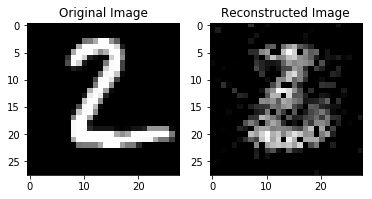

In [19]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))
if(use_gpu):
    outputImg = net(Variable((TestImg.double().cuda())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28).cpu()
else:
    outputImg = net(Variable((TestImg.double())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28)
    
TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

    

### Encoder Weights Visualisation

In [20]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

init_weights = (1+ init_weights)*127.5
trained_weights = (1+ trained_weights)*127.5
if(use_gpu):
    init_weights = init_weights.view(-1, 280, 280).byte().cpu()
    trained_weights = trained_weights.view(-1, 280, 280).byte().cpu()
else:
    init_weights = init_weights.view(-1, 280, 280).byte()
    trained_weights = trained_weights.view(-1, 280, 280).byte()
    
d_weights= init_weights - trained_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

In [22]:
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


### Remove decoder and place classifier:

In [23]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


### Define Optimizer:

In [29]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr= 0.01, momentum =0.9)

### Train Classifier:

In [30]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data[0]
    inputs = TestImages.double()/255
    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.size()[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

C:\Users\Lenovo\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration: 1 / 30  ;  Training Loss: 1.460818 ; Testing Acc: 81.000000 
At Iteration: 2 / 30  ;  Training Loss: 0.623352 ; Testing Acc: 86.000000 
At Iteration: 3 / 30  ;  Training Loss: 0.473105 ; Testing Acc: 88.000000 
At Iteration: 4 / 30  ;  Training Loss: 0.412325 ; Testing Acc: 89.000000 
At Iteration: 5 / 30  ;  Training Loss: 0.378391 ; Testing Acc: 90.000000 
At Iteration: 6 / 30  ;  Training Loss: 0.355956 ; Testing Acc: 90.000000 
At Iteration: 7 / 30  ;  Training Loss: 0.339354 ; Testing Acc: 91.000000 
At Iteration: 8 / 30  ;  Training Loss: 0.326139 ; Testing Acc: 91.000000 
At Iteration: 9 / 30  ;  Training Loss: 0.315069 ; Testing Acc: 91.000000 
At Iteration: 10 / 30  ;  Training Loss: 0.305443 ; Testing Acc: 91.000000 
At Iteration: 11 / 30  ;  Training Loss: 0.296765 ; Testing Acc: 92.000000 
At Iteration: 12 / 30  ;  Training Loss: 0.288814 ; Testing Acc: 92.000000 
At Iteration: 13 / 30  ;  Training Loss: 0.281420 ; Testing Acc: 92.000000 
At Iteration: 14 / 30

### Encoder Weight Visualisation

In [31]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

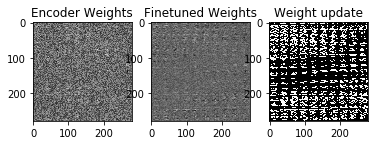

In [32]:
cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5

if use_gpu:
    cll_weights = cll_weights.view(-1,280,280).byte().cpu()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte().cpu()
else:
    cll_weights = cll_weights.view(-1,280,280).byte()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte()

d_weights = cll_weights - cll_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(cll_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(cll_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

### Classifier Weights Visualization:

In [33]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

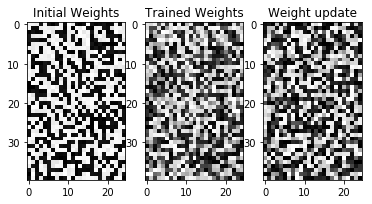

In [34]:
init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()